#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [ ]:
import warnings
import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Union, Tuple
from phik import phik_matrix

In [158]:
warnings.filterwarnings('ignore')
RANDOM_STATE = 0
TEST_SIZE = 0.1

Импорт библиотек, настройка окружения для обучения

## Анализ

In [159]:
def get_data(path: str, 
             idx_col: Union[int, List[int]], 
             parse_dates: Union[int, List[int]]
            ) -> pd.DataFrame:
    data = pd.read_csv(path, index_col=[idx_col], parse_dates=[parse_dates])
    data.sort_index(inplace=True)
    data = data.resample('1H').sum()
    return data

In [ ]:
data = get_data('YOUR_DATA', 0, 0)

In [161]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


    Получения данных и приведение к нужному виду с ресемплированием по часу, столбец со временем выбран в качестве индекса.
    Данные присутствуют только за 5 месяцев 2018 года с начала марта по конец августа.

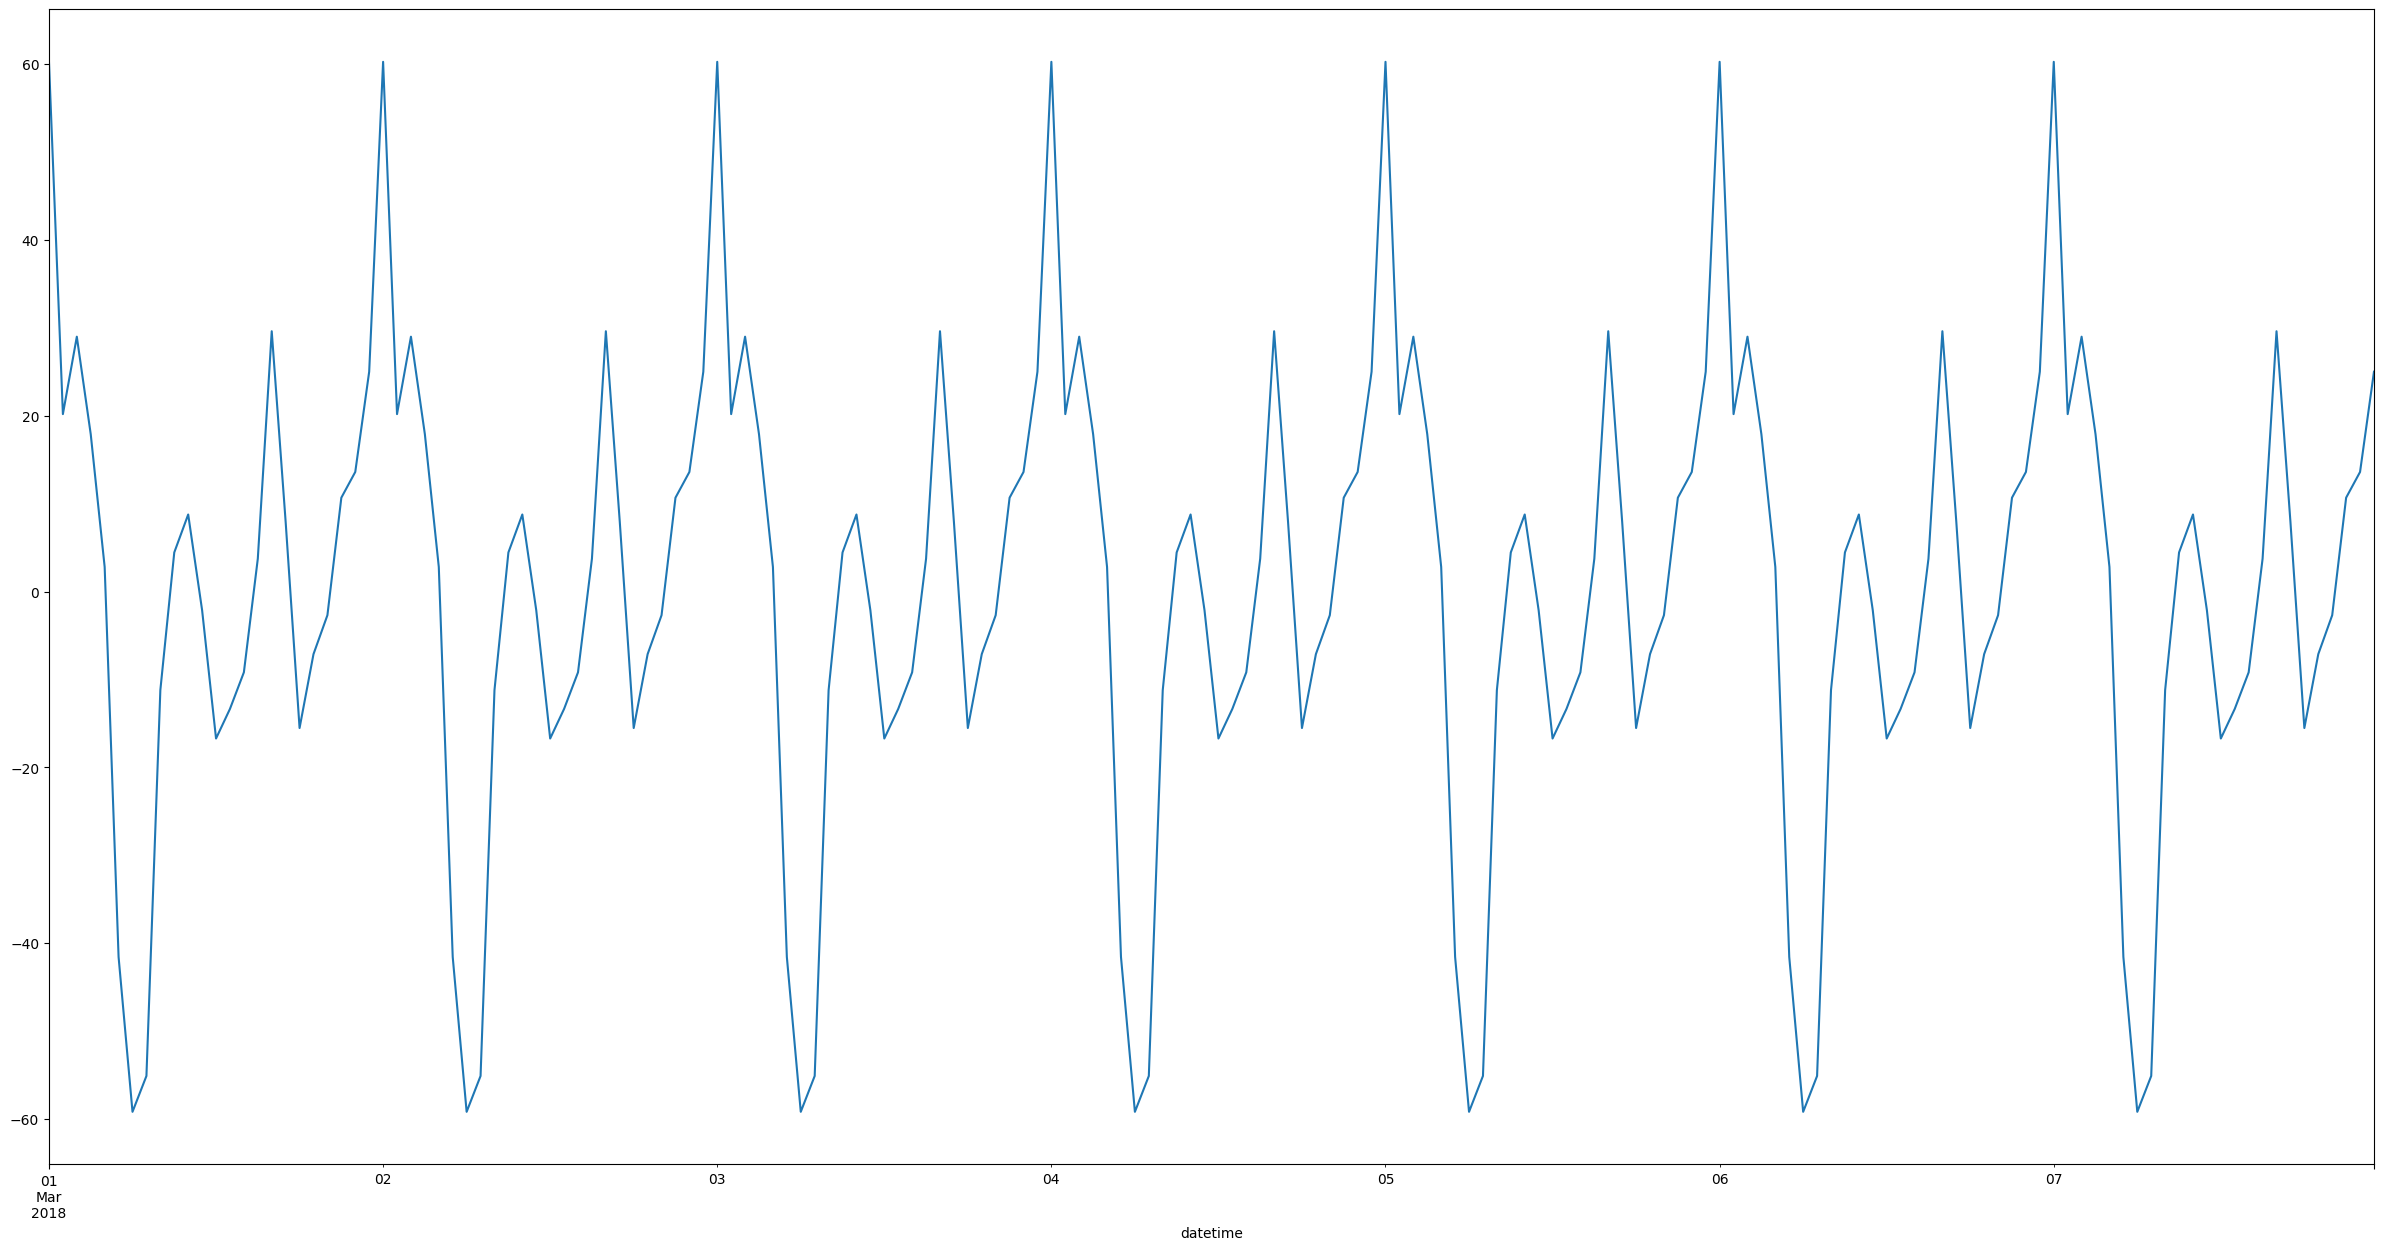

In [163]:
plt.figure(figsize=(30, 15))
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot();

    Временной ряд имеет стационарный стохастический процесс, это значит, что его распределение со временем не меняется.

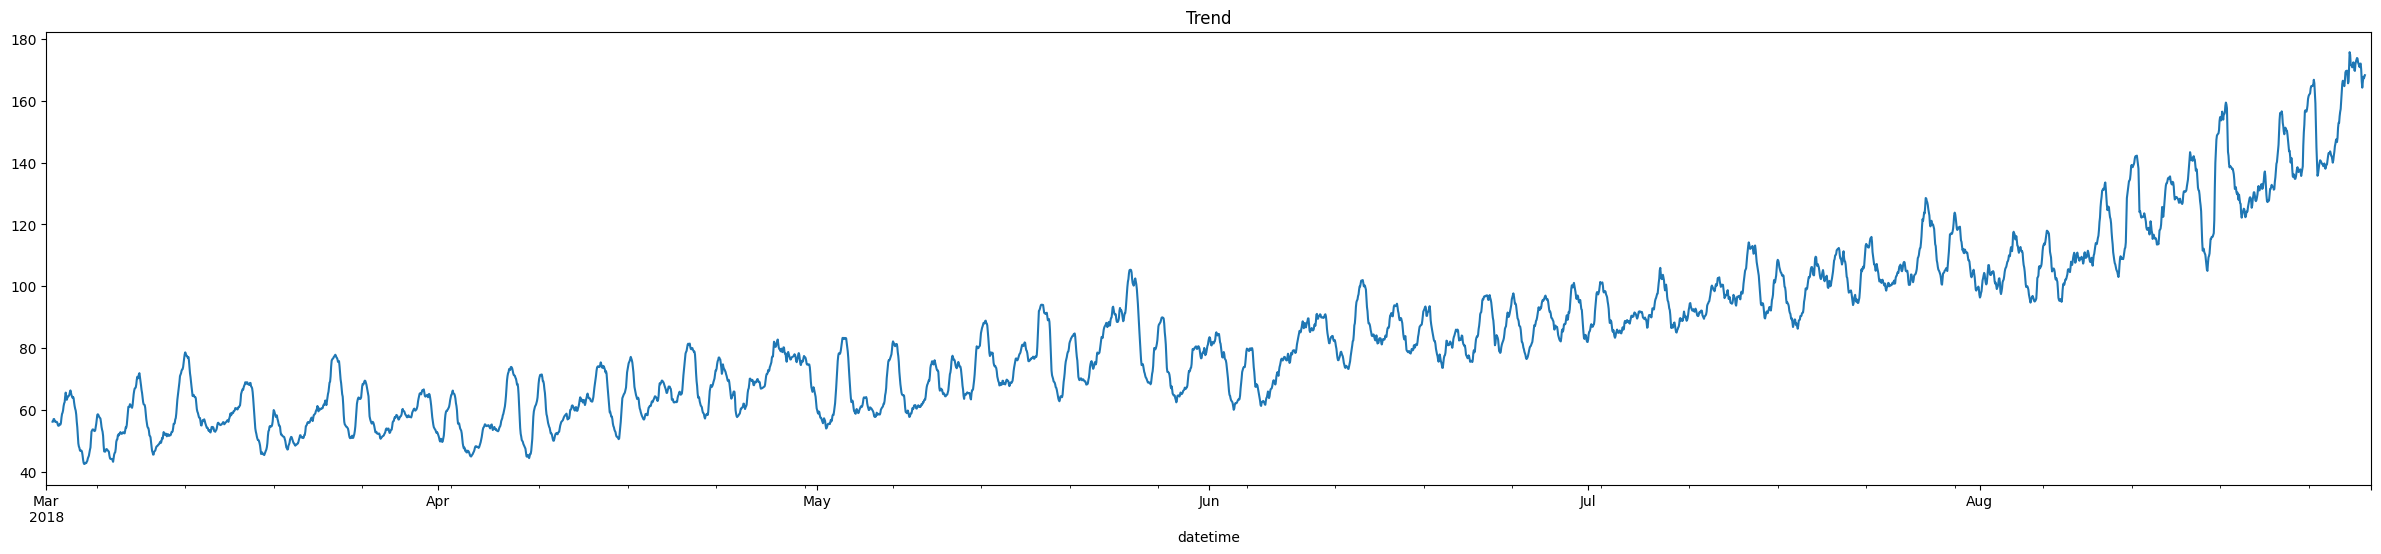

In [164]:
plt.figure(figsize=(30, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

    Тренд восходящий, но летом, мне кажется, так всегда, что спрос на такси выше, особенно в аэопортах, ведь люди прилетают на отдых. Так как картина неполная, долгосрочный это рост или нет неизвестно. 

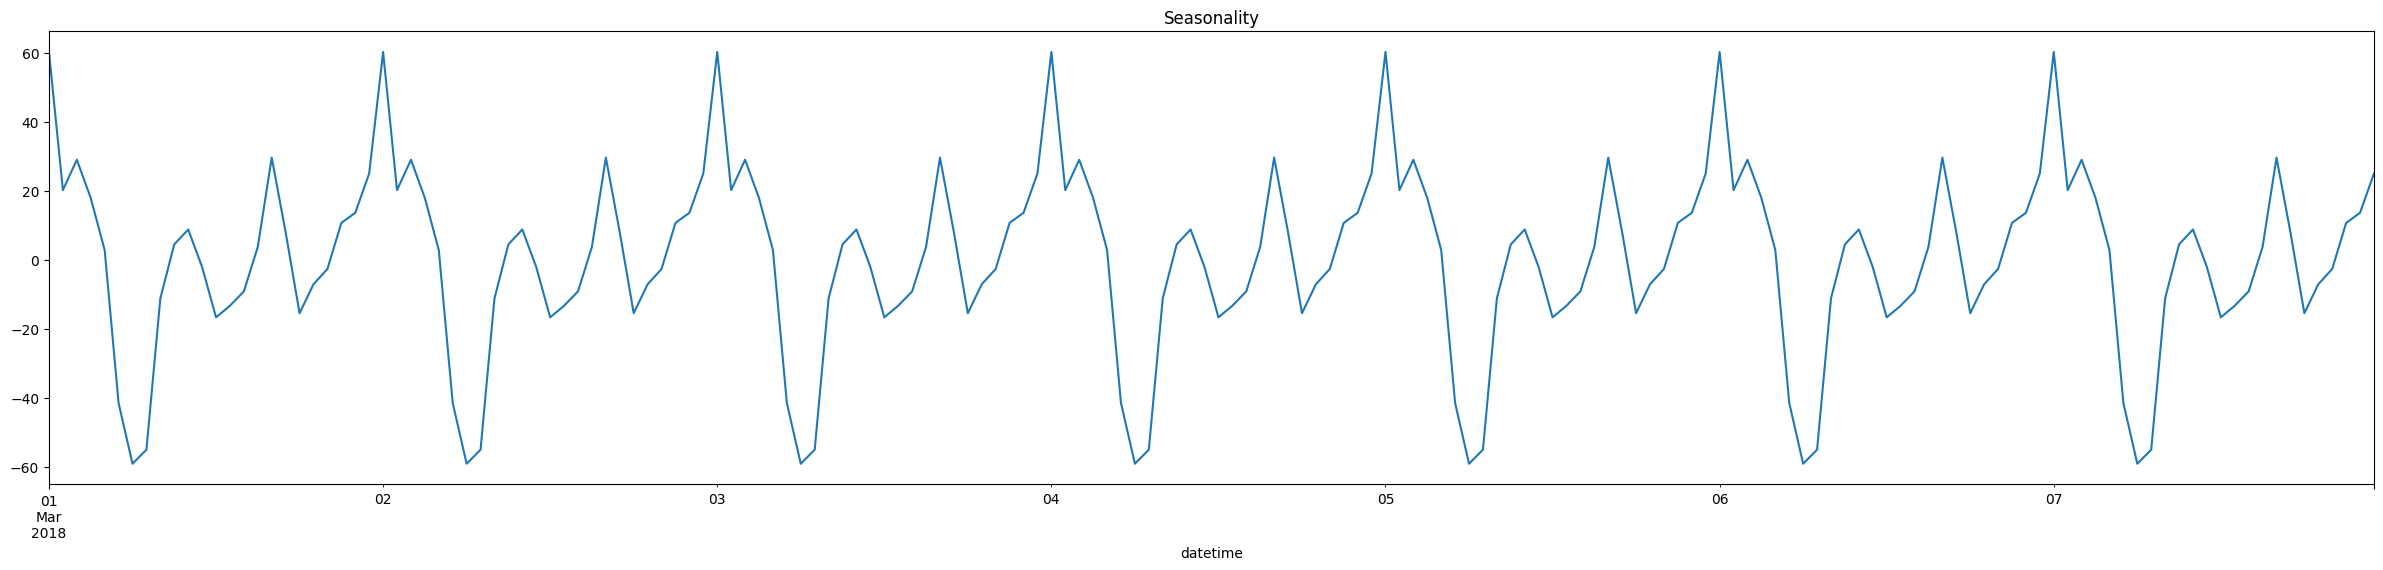

In [165]:
plt.figure(figsize=(30, 20))
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality');

    Из графика сезонности можно сказать, что самый низкий спрос на такси утром и самый высокий спрос ночью.

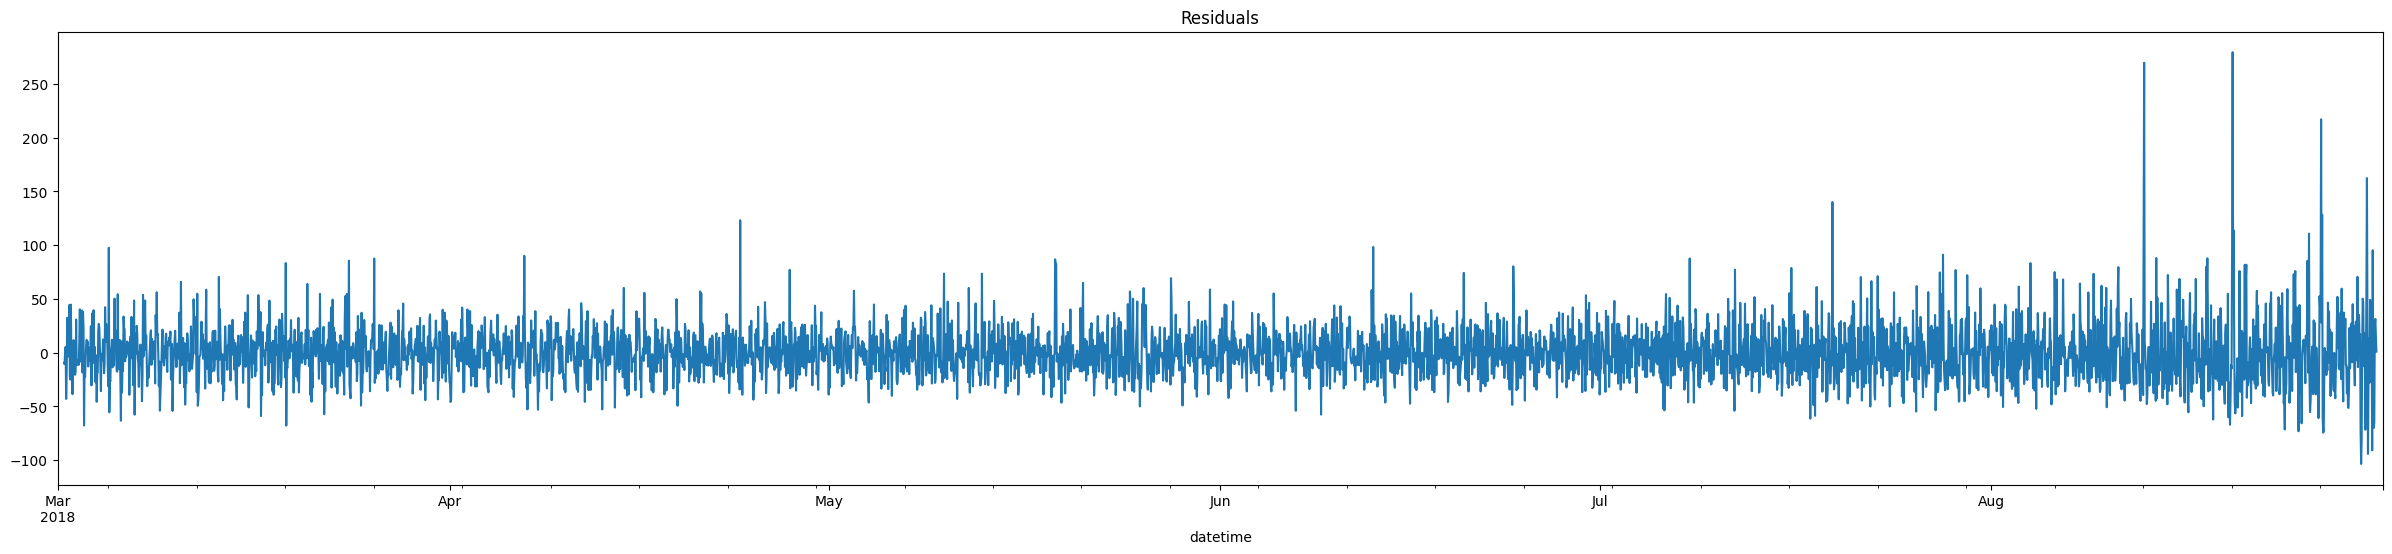

In [166]:
plt.figure(figsize=(30, 20))
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals');

    Остатки

    Выводы по анализу:

        -Данные присутсвуют неполные, всего за 5 месяцев с марта по конец августа 2018 года.
        -Спрос на такси имеет восходящий тренд в летние месяцы, но его долгосрочная динамика требует дополнительных данных.
        -Временной ряд имеет стационарный стохастический процесс.
        -Самый высокий спрос на такси в ночное время суток, около 12 ночи.
        

## Обучение

In [167]:
def make_features(data: pd.DataFrame) -> pd.DataFrame:
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.dayofweek >= 5
    data['is_night'] = (data['hour'] >= 0) & (data['hour'] <= 5)
    for lag in [24, 48, 72]:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    for window in [3, 6, 12, 24]:
        data[f'rolling_mean_{window}'] = data['num_orders'].shift().rolling(window).mean()
    return data

In [168]:
make_features(data)
print(data.head())

                     num_orders  hour  day  dayofweek  is_weekend  is_night  \
datetime                                                                      
2018-03-01 00:00:00         124     0    1          3       False      True   
2018-03-01 01:00:00          85     1    1          3       False      True   
2018-03-01 02:00:00          71     2    1          3       False      True   
2018-03-01 03:00:00          66     3    1          3       False      True   
2018-03-01 04:00:00          43     4    1          3       False      True   

                     lag_24  lag_48  lag_72  rolling_mean_3  rolling_mean_6  \
datetime                                                                      
2018-03-01 00:00:00     NaN     NaN     NaN             NaN             NaN   
2018-03-01 01:00:00     NaN     NaN     NaN             NaN             NaN   
2018-03-01 02:00:00     NaN     NaN     NaN             NaN             NaN   
2018-03-01 03:00:00     NaN     NaN     NaN       9

    -Добавлены новые фичи для обучения, отдельно выделены данные за час, день и день недели, делать больше смысла нет данных мало, также является ли день недели выходным и ночное ли время суток. 
    
    -Добавлены лаги за 24, 48, 72 часа.

    -Добавлено скользящее среднее за 3, 6, 12, 24, 48 часов.

In [169]:
def data_split(data: pd.DataFrame, drop_col: str
               ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    train, test = train_test_split(
        data,
        shuffle=False,
        test_size=TEST_SIZE)
    train = train.dropna()
    X_train = train.drop(columns=drop_col)
    y_train = train.num_orders
    X_test = test.drop(columns=drop_col)
    y_test = test.num_orders
    return X_train, X_test, y_train, y_test
    

In [170]:
X_train, X_test, y_train, y_test = data_split(data, 'num_orders')

In [171]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3902, 12) (442, 12) (3902,) (442,)


    Удалены пропуски, данные поделены на выборки в функции

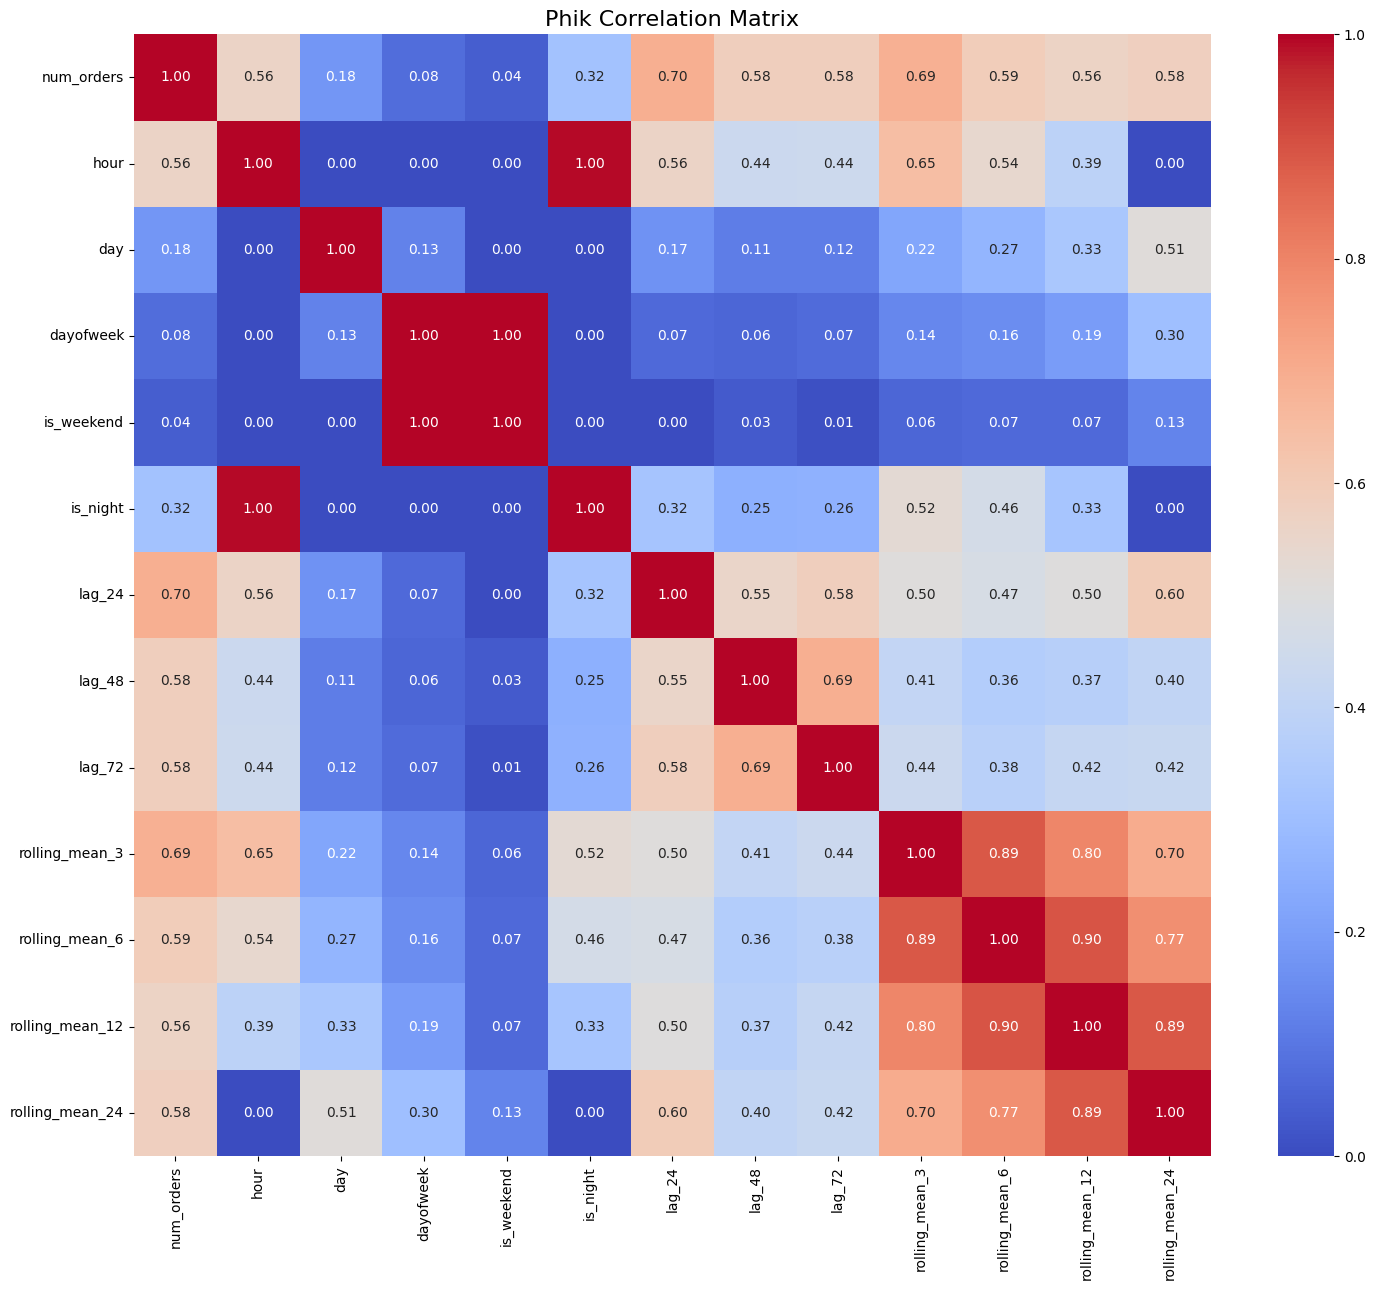

In [172]:
plt.figure(figsize=(15, 13))
sns.heatmap(phik_matrix(data, interval_cols=['num_orders', 
                                             'hour',
                                             'day', 
                                             'dayofweek',
                                             'lag_24',
                                             'lag_48',
                                             'lag_72',
                                             'rolling_mean_3',
                                             'rolling_mean_6',
                                             'rolling_mean_12',
                                             'rolling_mean_24']), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Phik Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

    Мультиколлинеарности в матрице корреляции нет, в обучении будут использованы все признаки. 

    Для обучения буду использовать оптуну для подбора гиперпарамтеров, и две модели LightGBM и обычную линейную регрессию. Обучение будет проходить на кросс валидации.

In [173]:
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'objective': 'regression', 
        'metric': 'rmse',
        'verbosity': -1,
        'random_state': RANDOM_STATE
    }
    
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            callbacks=[
                lgb.early_stopping(stopping_rounds=60, verbose=False),
                lgb.log_evaluation(False)
            ]
        )
        
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        cv_scores.append(score)
    
    return np.mean(cv_scores)

In [174]:
study_lgb = optuna.create_study(direction='minimize')  
study_lgb.optimize(objective_lgb, n_trials=100)

[I 2025-04-26 13:39:34,934] A new study created in memory with name: no-name-f7cf573c-ad92-4999-8115-0626cba2b056
[I 2025-04-26 13:39:35,118] Trial 0 finished with value: 39.68617734473827 and parameters: {'num_leaves': 170, 'learning_rate': 0.00021752286371983485, 'max_depth': 14, 'min_child_samples': 143, 'subsample': 0.9234445338441658, 'colsample_bytree': 0.5148084320769817, 'reg_alpha': 0.48987365471872235, 'reg_lambda': 9.410818891001307}. Best is trial 0 with value: 39.68617734473827.
[I 2025-04-26 13:39:35,284] Trial 1 finished with value: 33.30958987126017 and parameters: {'num_leaves': 205, 'learning_rate': 0.004063145676666891, 'max_depth': 14, 'min_child_samples': 200, 'subsample': 0.9621286935844664, 'colsample_bytree': 0.5772356112082924, 'reg_alpha': 0.008520492001494174, 'reg_lambda': 0.06730801241670763}. Best is trial 1 with value: 33.30958987126017.
[I 2025-04-26 13:39:35,830] Trial 2 finished with value: 22.546129781599912 and parameters: {'num_leaves': 101, 'learni

In [175]:
print("\nBest trial:")
trial_lgb = study_lgb.best_trial

print(f"  RMSE: {trial_lgb.value:.4f}")
print("  Params: ")
for key, value in trial_lgb.params.items():
    print(f"    {key}: {value}")


Best trial:
  RMSE: 22.1236
  Params: 
    num_leaves: 123
    learning_rate: 0.11266186781165848
    max_depth: 12
    min_child_samples: 73
    subsample: 0.6494772859022614
    colsample_bytree: 0.5298363460915876
    reg_alpha: 1.5243061050005672e-05
    reg_lambda: 3.7951529599830004e-05


    Лучший результат у модели LightGBM это RMSE равная 22.1395, подобранные гиперпараметры выведены.

In [176]:
def objective_lr(trial):
    params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'positive': trial.suggest_categorical('positive', [True, False]),
        'n_jobs': -1  
    }
    
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LinearRegression(**params)
        model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        cv_scores.append(score)
    
    return np.mean(cv_scores)


In [177]:
study_lr = optuna.create_study(direction='minimize')  
study_lr.optimize(objective_lr, n_trials=10)

[I 2025-04-26 13:40:11,460] A new study created in memory with name: no-name-898fdf50-e4c6-421e-87f8-ceeec5c8cdf5
[I 2025-04-26 13:40:11,481] Trial 0 finished with value: 23.600295298747568 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 0 with value: 23.600295298747568.
[I 2025-04-26 13:40:11,501] Trial 1 finished with value: 23.786703270012204 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 23.600295298747568.
[I 2025-04-26 13:40:11,520] Trial 2 finished with value: 23.570869537016193 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 2 with value: 23.570869537016193.
[I 2025-04-26 13:40:11,538] Trial 3 finished with value: 23.600295298747568 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 2 with value: 23.570869537016193.
[I 2025-04-26 13:40:11,555] Trial 4 finished with value: 23.759278962970132 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial

In [178]:
print("\nBest trial:")
trial_lr = study_lr.best_trial

print(f"  RMSE: {trial_lr.value:.4f}")
print("  Params: ")
for key, value in trial_lr.params.items():
    print(f"    {key}: {value}")


Best trial:
  RMSE: 23.5709
  Params: 
    fit_intercept: True
    positive: False


    Лучший результат у линейной регрессии RMSE = 23.5709.

    Выводы по обучнию:

        -Созданы новые фичи для обучения, данные поделены на выборки.
        -Выбраны две модели LightGBM и линейная регрессия, обе модели легкие в обучении и не требуют много ресурсов, в качестве подбора гиперпараметров использовалась оптуна.
        -По результатам для тестирования выбрана LightGBM с RMSE равной 22.1395 на кросс валидации.

## Тестирование

In [179]:
best_params = study_lgb.best_trial.params
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain)

final_model = lgb.train(
    best_params,
    dtrain,
    valid_sets=[dtest], 
    num_boost_round=1500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=1000, verbose=True),
        lgb.log_evaluation(50) 
    ]
)

y_test_pred = final_model.predict(X_test)


Training until validation scores don't improve for 1000 rounds
[50]	valid_0's l2: 1735.9
[100]	valid_0's l2: 1626.98
[150]	valid_0's l2: 1579.36
[200]	valid_0's l2: 1569.87
[250]	valid_0's l2: 1576.92
[300]	valid_0's l2: 1576.37
[350]	valid_0's l2: 1585.78
[400]	valid_0's l2: 1598.44
[450]	valid_0's l2: 1614.56
[500]	valid_0's l2: 1624.77
[550]	valid_0's l2: 1643.57
[600]	valid_0's l2: 1653.23
[650]	valid_0's l2: 1664.38
[700]	valid_0's l2: 1683.52
[750]	valid_0's l2: 1697.11
[800]	valid_0's l2: 1712.14
[850]	valid_0's l2: 1719
[900]	valid_0's l2: 1727.64
[950]	valid_0's l2: 1741.27
[1000]	valid_0's l2: 1752.82
[1050]	valid_0's l2: 1766.13
[1100]	valid_0's l2: 1779.59
[1150]	valid_0's l2: 1785.09
Early stopping, best iteration is:
[177]	valid_0's l2: 1564.1


In [180]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE: {test_rmse:.4f}")


Test RMSE: 39.5487


    На тесте тестовая RMSE равна 39.3514, условию задачи соответствует.

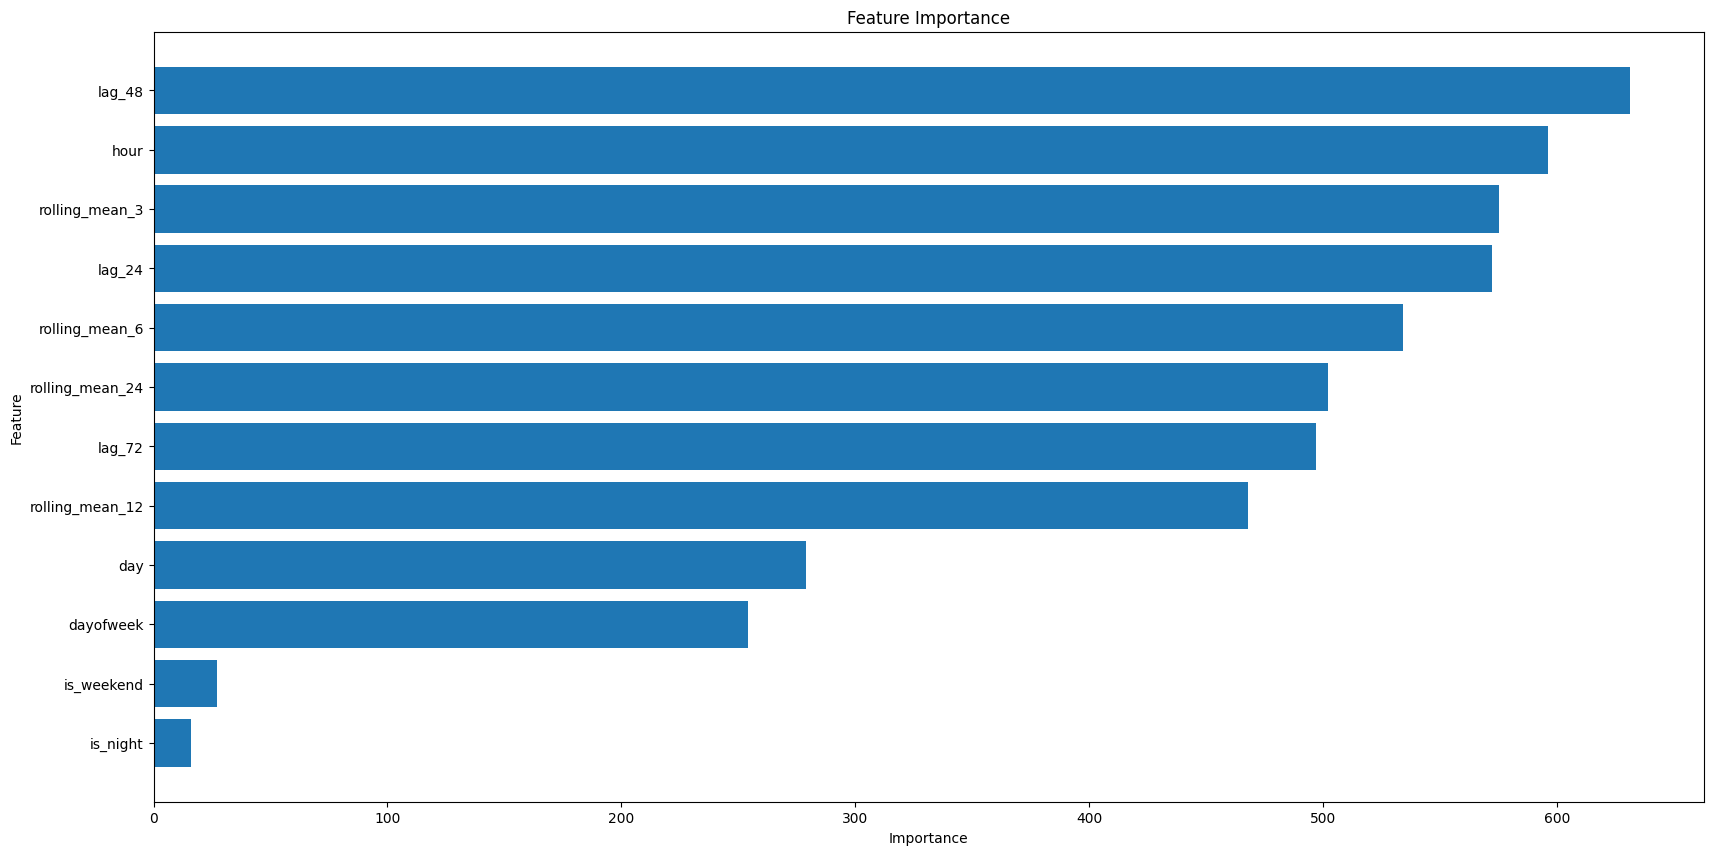

In [181]:
feature_importance_df = pd.DataFrame({
    'feature': final_model.feature_name(),
    'importance': final_model.feature_importance()
})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(20, 10))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


    Самые важные признаки для модели оказались скользящее среднее за 3 часа, лаг за 24 и 48 часов.

    В проекте по прогнозированию заказов такси в аэропортах для компании «Чётенькое такси» можно сделать такие выводы по работе:

        -Данные были загружены проанализированы и созданые новые фичи для обучения моделей.
        -В проекте были использованы две модели LightGBM и линейная регрессия в виду своей легкости и эффективности.
        -Лучшей оказалась LightGBM с RMSE на тесте равной 39.3514.

    Улучшить показатели метрики и работы модели в целом можно, нужны данные за больший период времени, хотя бы за год, чтобы увидеть все сезоны.